<h1 align="center"> Image Denoising using a Deep Convolutional Autoencoder </h1>

<h1 align="center"> <a href="https://github.com/bagheri365/" target="_blank" rel="noopener noreferrer">Alireza Bagheri</a></h1>

<h1>Table of contents</h1>
<ul>   
    <li><a href="#Data">Data Preparation</a> </li> 
    <ul> 
        <li><a href="#load_data">Load Data</a> </li>
        <li><a href="#scale_data"> Scale and Reshape the Data </a></li>
        <li><a href="#noisy_data"> Add Noise to the Data </a> </li>
    </ul> 
    <li><a href="#Denoising_autencoder"> Denoising Autoencoder </a></li>
    <ul> 
        <li><a href="#encoder"> Build Encoder Model </a></li>
        <li><a href="#decoder"> Build Decoder Model </a></li> 
        <li><a href="#autoencoder"> Train the Autoencoder </a></li>
    </ul>     
    <li><a href="#results"> Results </a></li>
    <li><a href="#ref"> Reference </a></li>
</ul> 

## Data Preparation <a name="Data"></a>

### Load Data <a name="load_data"></a>

In [1]:
from tensorflow.keras.datasets import mnist

(X_train, _), (X_test, _) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Scale and Reshape the Data  <a name="scale_data"></a>

In [2]:
# Scale X to range between 0 and 1
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Reshape X to (n_samples/batch_size, height, width, n_channels)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


### Add Noise to the Data  <a name="noisy_data"></a>

In [3]:
import numpy as np

noise_factor = 0.5

noise = noise_factor * np.random.normal(loc= 0.5, scale= 0.5, size= X_train.shape) 
X_train_noisy = X_train + noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

noise = noise_factor * np.random.normal(loc= 0.5, scale= 0.5, size= X_test.shape) 
X_test_noisy = X_test + noise
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

## Denoising Autoencoder <a name="Denoising_autencoder"></a>
 
### Build Encoder Model <a name="encoder"></a>

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation
from tensorflow.keras.models import Model
import warnings; warnings.filterwarnings('ignore')

input_img = Input(shape=(28,28,1), name='Encoder_input')

# Encoder
Enc = Conv2D(16, (3, 3), padding='same', activation='relu', name='Enc_conv2d_1')(input_img)
Enc = MaxPooling2D(pool_size=(2,2), padding='same', name='Enc_max_pooling2d_1')(Enc)
Enc = Conv2D(8,(3, 3), padding='same', activation='relu', name='Enc_conv2d_2')(Enc)
Enc = MaxPooling2D(pool_size=(2,2), padding='same', name='Enc_max_pooling2d_2')(Enc)
Encoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid', name='Enc_conv2d_3')(Enc)

# Instantiate the Encoder Model
encoder = Model(inputs = input_img, outputs = Encoded)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
Enc_conv2d_1 (Conv2D)        (None, 28, 28, 16)        160       
_________________________________________________________________
Enc_max_pooling2d_1 (MaxPool (None, 14, 14, 16)        0         
_________________________________________________________________
Enc_conv2d_2 (Conv2D)        (None, 14, 14, 8)         1160      
_________________________________________________________________
Enc_max_pooling2d_2 (MaxPool (None, 7, 7, 8)           0         
_________________________________________________________________
Enc_conv2d_3 (Conv2D)        (None, 7, 7, 1)           73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
_________________________________________________________

### Build Decoder Model <a name="decoder"></a>

In [5]:
# Decoder
Dec = Conv2D(8, (3, 3), padding='same', activation='relu', name ='Dec_conv2d_1')(Encoded)
Dec = UpSampling2D((2, 2), name = 'Dec_upsampling2d_1')(Dec)
Dec = Conv2D(16, (3, 3), padding='same', activation='relu', name ='Dec_conv2d_2')(Dec)
Dec = UpSampling2D((2, 2), name = 'Dec_upsampling2d_2')(Dec)
decoded = Conv2D(1,(3, 3), padding='same', activation='sigmoid', name ='Dec_conv2d_3')(Dec)

# Instantiate the Autoencoder Model
autoencoder = Model(inputs = input_img, outputs = decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
Enc_conv2d_1 (Conv2D)        (None, 28, 28, 16)        160       
_________________________________________________________________
Enc_max_pooling2d_1 (MaxPool (None, 14, 14, 16)        0         
_________________________________________________________________
Enc_conv2d_2 (Conv2D)        (None, 14, 14, 8)         1160      
_________________________________________________________________
Enc_max_pooling2d_2 (MaxPool (None, 7, 7, 8)           0         
_________________________________________________________________
Enc_conv2d_3 (Conv2D)        (None, 7, 7, 1)           73        
_________________________________________________________________
Dec_conv2d_1 (Conv2D)        (None, 7, 7, 8)           80  

### Train the Autoencoder <a name="autoencoder"></a>
#### Compile and train the autoencoder

In [6]:
# Compile the autoencoder
autoencoder.compile(loss='mse', optimizer='adam') 

# Train the autoencoder
history = autoencoder.fit(X_train_noisy, X_train, 
                epochs = 10, 
                batch_size = 20, 
                shuffle = True, 
                validation_split = 1/6).history

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 325s 7ms/sample - loss: 0.0270 - val_loss: 0.0176
Epoch 2/10
50000/50000 [==============================] - 431s 9ms/sample - loss: 0.0162 - val_loss: 0.0155
Epoch 3/10
50000/50000 [==============================] - 471s 9ms/sample - loss: 0.0147 - val_loss: 0.0143
Epoch 4/10
50000/50000 [==============================] - 400s 8ms/sample - loss: 0.0140 - val_loss: 0.0138
Epoch 5/10
50000/50000 [==============================] - 429s 9ms/sample - loss: 0.0135 - val_loss: 0.0134
Epoch 6/10
50000/50000 [==============================] - 476s 10ms/sample - loss: 0.0132 - val_loss: 0.0131
Epoch 7/10
50000/50000 [==============================] - 518s 10ms/sample - loss: 0.0129 - val_loss: 0.0128
Epoch 8/10
50000/50000 [==============================] - 529s 11ms/sample - loss: 0.0127 - val_loss: 0.0127
Epoch 9/10
50000/50000 [==============================] - 516s 10ms/sample - loss: 

#### Plot loss versus epochs

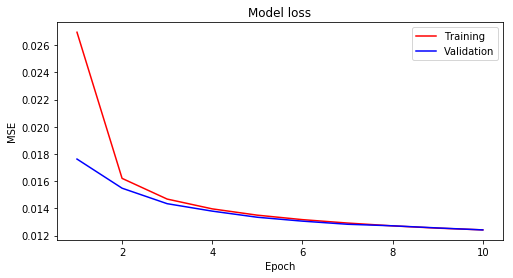

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

tr_loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(tr_loss)+1)

fig = plt.figure(figsize=(8, 4))
fig.tight_layout()
plt.plot(epochs, tr_loss,'r')
plt.plot(epochs, val_loss,'b')
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### Save the trained model

In [8]:
from keras.models import model_from_json

# Save the Encoder
model_json = encoder.to_json()
with open("logs/Encoder_model.json", "w") as json_file:
    json_file.write(model_json)
encoder.save_weights("logs/Encoder_weights.h5")

# Save the Autoencoder
model_json = autoencoder.to_json()
with open("logs/Autoencoder_model.json", "w") as json_file:
    json_file.write(model_json)
autoencoder.save_weights("logs/Autoencoder_weights.h5")

### Results <a name="results"></a>

#### Load the trained model

In [9]:
from tensorflow.keras.models import model_from_json
import warnings; warnings.filterwarnings('ignore')

with open('logs/Encoder_model.json', 'r') as f:
    Myencoder = model_from_json(f.read())
Myencoder.load_weights("logs/Encoder_weights.h5")

with open('logs/Autoencoder_model.json', 'r') as f:
    MyAutoencoder = model_from_json(f.read())
MyAutoencoder.load_weights("logs/Autoencoder_weights.h5")

#### Plot denoised images

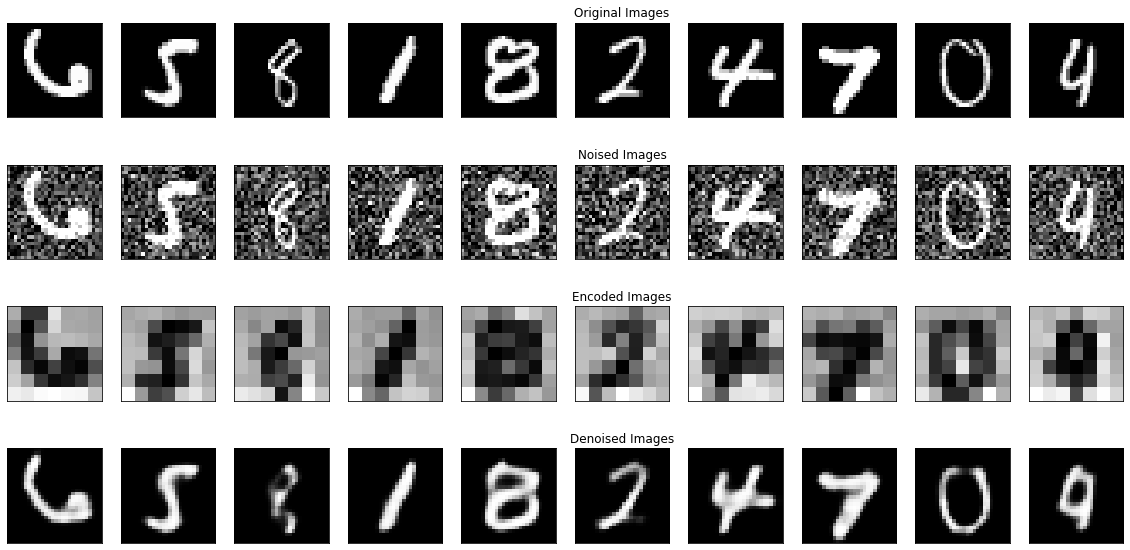

In [10]:
# Pick randomly some images from test set
num_images = 10
random_test_images = np.random.randint(X_test.shape[0], size= num_images)

# Predict the Encoder and the Autoencoder outputs from the noisy test images
encoded_imgs = Myencoder.predict(X_test_noisy)
decoded_imgs = MyAutoencoder.predict(X_test_noisy)

plt.figure(figsize=(20, 10))
fig.tight_layout()
for i, image_idx in enumerate(random_test_images):
    # Plot original image
    ax = plt.subplot(4, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == num_images//2:
        ax.set_title('Original Images')
 
    # Plot noised image 
    ax = plt.subplot(4, num_images, num_images + i + 1)
    plt.imshow(X_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == num_images//2:
        ax.set_title('Noised Images')
        
    # Plot encoded image
    ax = plt.subplot(4, num_images, 2*num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(7, 7))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == num_images//2:
        ax.set_title('Encoded Images')
    
    # Plot reconstructed image
    ax = plt.subplot(4, num_images, 3*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == num_images//2:
        ax.set_title('Denoised Images')
plt.show()

### Reference <a name="ref"></a>

https://keras.io/examples/mnist_denoising_autoencoder/